# Dataset Creation - TRsim Experiment 3

R = amount of starting configurations with B boxes

B = amount of boxes in the room at the start

## Step 1: Create the foundation files

Within the folder data/scene_datasets/TRsim_exp3/stages/:

- (1x) TRsim_room.glb: floor + walls + ceiling mesh.

- (Rx) TRsim.ply: export the room, as well as the boxes.

- (1x) TRsim.house: .house file describing the room geometry, and the box locations.

Within the folder data/scene_datasets/TRsim_exp3/objects/:

- (1x) TRsim_box.glb: box mesh.

And:

- (1x) TRsim_material_config.json: Acoustic properties file

## Step 1: Modify the _semantic.ply

Modify the .ply file to change the last x vertices (boxes) to different locations, as well as adding the right material "object_id". Save in the format "~/ss/data/scene_datasets/TRsim_exp3/stages/TRsim_room{n}\_{amount of boxes removed}\_{ids of boxes removed}_semantic.ply". 

## Step 2: Create ground truth label file

The label is saved in the filename, as it corresponds to the amount of boxes removed.

## Step 3: Run SoundSpaces 2.0

Load the file, rename to "treated_room_object_semantic.ply", run simulation, and save as "N.wav".

## Step 4: Concatenate mic channels

For now, the simulations are saved per mic. For the multi-channel cases, these files need to be concatenated into one "deconvolved.npy".

--------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
import numpy as np
import os

from plyfile import PlyData, PlyElement

In [3]:
BASE_DIR = "/home/student/ss"
SIM_DIR = os.path.join(BASE_DIR, "data/scene_datasets/TRsim_exp3")
STAGES_DIR = os.path.join(BASE_DIR, SIM_DIR, "stages")
print(STAGES_DIR)

/home/student/ss/data/scene_datasets/TRsim_exp3/stages


### Step 1: Modify the _semantic.ply

Save with the name "~/ss/data/scene_datasets/TRsim_exp3/stages/TRsim_room{n}\_{amount of boxes removed}\_{ids of boxes removed}_semantic.ply"

In [4]:
import itertools

def create_empty_ply(base_ply):
    base_verts = np.array(base_ply['vertex'].data) # (40,), where the first 33 correspond to the room, the last 8 to the box

    verts_dtype = [
        ('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
        ('red', 'u1'), ('green', 'u1'), ('blue', 'u1'),
        ('object_id', 'i4')] # remove the alpha, add the object_id
    
    new_verts = np.empty(len(base_verts), dtype=verts_dtype)

    new_verts['x'] = base_verts['x'] # last 8 will be overwritten
    new_verts['y'] = base_verts['y'] # last 8 will be overwritten
    new_verts['z'] = base_verts['z'] # does not change between measurement locations (vertex order does not change)
    new_verts['red'] = base_verts['red'] # same
    new_verts['green'] = base_verts['green'] # same
    new_verts['blue'] = base_verts['blue'] # same

    for v in range(len(new_verts)): # set all materials, does not change between measurement locations (vertex order does not change)
        if new_verts['red'][v] == 254:
            new_verts['object_id'][v] = 1 # wall material
        elif new_verts['green'][v] == 254:
            new_verts['object_id'][v] = 0 # floor material
        elif new_verts['blue'][v] == 254:
            new_verts['object_id'][v] = 2 # ceiling material
        else:
            new_verts['object_id'][v] = 3 # object material        
        
    faces = base_ply['face'] # unchanged, just sets which vertice ids correspond to which face (and vertex order does not change)
    
    return new_verts, faces

def remove_boxes_from_ply(new_verts, faces, boxes_to_remove):
    """
    Remove multiple boxes at once.
    boxes_to_remove: list of integers, the box indices to remove
    """
    # Step 1: find all box vertices
    is_box_vertex = new_verts['object_id'] == 3
    box_vertex_indices_all = np.where(is_box_vertex)[0]

    # Step 2: select the vertices corresponding to the boxes to remove
    box_vertex_indices_to_remove = []
    for box in boxes_to_remove:
        start = box * 8
        end = start + 8
        box_vertex_indices_to_remove.extend(box_vertex_indices_all[start:end])
    box_vertex_indices_to_remove = np.array(box_vertex_indices_to_remove)

    # Step 3: remove faces referencing these vertices
    faces_data = np.array(faces.data)
    keep_face_mask = []
    for face in faces_data:
        vertex_ids = face['vertex_indices']
        if not any(v in box_vertex_indices_to_remove for v in vertex_ids):
            keep_face_mask.append(True)
        else:
            keep_face_mask.append(False)
    keep_face_mask = np.array(keep_face_mask)
    remaining_faces_data = faces_data[keep_face_mask]

    # Step 4: remove the vertices
    keep_vertex_mask = np.ones(len(new_verts), dtype=bool)
    if len(box_vertex_indices_to_remove) == 0:
        remaining_verts = new_verts
    else:
        keep_vertex_mask[box_vertex_indices_to_remove] = False
        remaining_verts = new_verts[keep_vertex_mask]

    # Step 5: remap face indices
    old_to_new = np.full(len(new_verts), -1, dtype=int)
    old_to_new[np.where(keep_vertex_mask)[0]] = np.arange(len(remaining_verts))
    for i, face in enumerate(remaining_faces_data):
        remaining_faces_data[i]['vertex_indices'] = [old_to_new[v] for v in face['vertex_indices']]

    remaining_faces = PlyElement.describe(remaining_faces_data, 'face')
    return remaining_verts, remaining_faces

def save_new_ply(mod_verts, mod_faces, boxes_removed, filename_prefix='TRsim_room_', mode='binary'):
    num_removed = len(boxes_removed)
    boxes_str = "".join(map(str, boxes_removed))
    filename = f"{filename_prefix}{num_removed}_{boxes_str}"
    
    if mode == 'binary':
        ply = PlyData([PlyElement.describe(mod_verts, 'vertex'), mod_faces], byte_order='<')
        ply.write(os.path.join(STAGES_DIR, filename + "_semantic.ply"))
    elif mode == 'ascii':
        ply = PlyData([PlyElement.describe(mod_verts, 'vertex'), mod_faces], text=True)
        ply.write(os.path.join(STAGES_DIR, filename + "_ascii.ply"))
    else:
        raise Exception("Mode must be 'binary' or 'ascii'")

In [18]:
# Parameters
B = 3  # number of boxes
R = [1]  # list of room indices

volume_labels = []

for r in R:
    base_ply = PlyData.read(os.path.join(STAGES_DIR, "base", f"TRsim_room{r}.ply"))
    new_verts, faces = create_empty_ply(base_ply)

    save_new_ply(new_verts, faces, [], filename_prefix=f'TRsim_room{r}_')
    # volume_labels.append(0)

    # Generate all combinations of boxes to remove (from 1 to B)
    for num_to_remove in range(0, B + 1):
        for boxes_to_remove in itertools.combinations(range(B), num_to_remove):
            remaining_verts, remaining_faces = remove_boxes_from_ply(new_verts, faces, list(boxes_to_remove))
            save_new_ply(remaining_verts, remaining_faces, boxes_to_remove, filename_prefix=f'TRsim_room{r}_')
            volume_labels.append(len(boxes_to_remove))

gt_label_file = os.path.join(BASE_DIR, "data/output/TRsim_exp3/try1", f"labels_{len(R)}rooms_{str(B)}boxes.npy")
np.save(gt_label_file, np.array(volume_labels).reshape(-1, 1))

In [19]:
assert len(volume_labels) == 2**B # amount of possible combinations, including the "no_box_removed" and "all_boxes_removed" situation

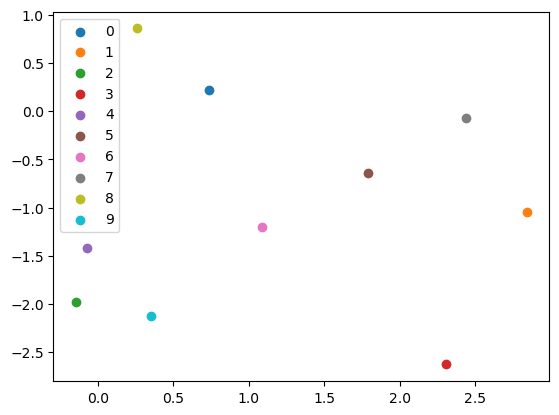

In [20]:
# TO FIND WHICH INDEX CORRESPONDS TO WHICH BOX IN THE MESH
import matplotlib.pyplot as plt

B = 10 # number of boxes

feet = 12
top_left = np.array([-47.5, 46.75])*25.4
bottom_right = np.array([10*feet+23.5, -12*feet - 19.625])*25.4

for box in range(B):
    is_box_vertex = new_verts['object_id'] == 3
    box_vertex_indices_all = np.where(is_box_vertex)[0]

    # Step 2: select the vertices corresponding to the box
    box_vertex_indices = []
    start = box * 8
    end = start + 8
    box_vertex_indices.extend(box_vertex_indices_all[start:end])
    box_vertex_indices = np.array(box_vertex_indices)
    # print("BOX: ", box)
    (x, y) = [new_verts[box_vertex_indices]['x'].mean(), new_verts[box_vertex_indices]['y'].mean()]
    # print(x,y)
    plt.scatter(x, y, label=box)
    plt.legend()

In [21]:
# TO FIND WHICH BOXES WERE REMOVED

B = 3  # number of boxes
boxes_to_remove_list = []

for num_to_remove in range(0, B + 1):
        for boxes_to_remove in itertools.combinations(range(B), num_to_remove):
            boxes_to_remove_list.append(boxes_to_remove)

INDICES = [4,5,6]
for i in range(2**B):#INDICES:   
    print(f"Index {i}: ", boxes_to_remove_list[i], "were removed" )

Index 0:  () were removed
Index 1:  (0,) were removed
Index 2:  (1,) were removed
Index 3:  (2,) were removed
Index 4:  (0, 1) were removed
Index 5:  (0, 2) were removed
Index 6:  (1, 2) were removed
Index 7:  (0, 1, 2) were removed


### Step 2: Create a ground truth label file

Based on the volume_labels that were saved. For B boxes, RIR = 2**B RIRs per mic were created. From this, ( RIR *(RIR-1))/2 input pairs can be formed. However, this would only capture the removal of boxes between situation 1 and 2. To capture also the possibility of adding boxes, permutation should be used (order matters). Then, there are (RIR * (RIR-1)) optional inputs. To be efficient, an iterable PyTorch dataloader will be used. Below code is just explorative.

In [ ]:
# To check how it works,.
import math

B = 3
N = 2**B
C = (N*(N-1))//2
P = (N*(N-1))

print("Amount of boxes: ", B)
print("Amount of RIRs (per mic): ", N)
print("Amount of possible input pairs (AB, no BA): ", C, "i.e. only removing boxes...")
print("Amount of possible input pairs (AB and BA): ", P, "i.e. adding as well as removing boxes")

for input_pair in itertools.permutations(range(N), 2):
    print(input_pair)
    for box in input_pair:
        print(f"Box {box} has volume change {volume_labels[box]}")
    print(f"The input pair has a volume change w.r.t. baseline of {volume_labels[input_pair[0]]-volume_labels[input_pair[1]]}")
    if volume_labels[input_pair[0]]-volume_labels[input_pair[1]] > 0:
        print("Also above zero")

Permutations:  56
Combinations:  28
Amount of boxes:  3
Amount of RIRs (per mic):  8
Amount of possible input pairs:  28
(0, 1)
Box 0 has volume change 0
Box 1 has volume change 1
The input pair has a volume change w.r.t. baseline of -1
(0, 2)
Box 0 has volume change 0
Box 2 has volume change 1
The input pair has a volume change w.r.t. baseline of -1
(0, 3)
Box 0 has volume change 0
Box 3 has volume change 1
The input pair has a volume change w.r.t. baseline of -1
(0, 4)
Box 0 has volume change 0
Box 4 has volume change 2
The input pair has a volume change w.r.t. baseline of -2
(0, 5)
Box 0 has volume change 0
Box 5 has volume change 2
The input pair has a volume change w.r.t. baseline of -2
(0, 6)
Box 0 has volume change 0
Box 6 has volume change 2
The input pair has a volume change w.r.t. baseline of -2
(0, 7)
Box 0 has volume change 0
Box 7 has volume change 3
The input pair has a volume change w.r.t. baseline of -3
(1, 0)
Box 1 has volume change 1
Box 0 has volume change 0
The inpu

### Step 3: Run SoundSpaces 2.0

Run Docker simsetup container with: 

(maybe: '''docker rm simsetup''')

'''docker run -it --gpus all --name simsetup -v ~/ss/examples:/sound-spaces/examples -v ~/ss/data:/sound-spaces/data soundspaces:U20cudaglheadless /bin/bash'''

'''cd sound-spaces'''

'''python examples/TRsim.py'''

### Step 4: Concatenate mic channels

In [23]:
import numpy as np
import os

C = 1
R = 50000
N = 10
S = 48000

TRSIM = 'TRsim_exp3'
FOLDER = 'try1'

deconv = np.zeros((N, 10, S))

if C == 1:
    mics = [0]
elif C == 2:
    mics = [0, 6]
elif C == 4:
    mics = [0, 5, 6, 9]
elif C == 10:
    mics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for n in mics:
    mic_rirs = np.load(BASE_DIR + f"/data/output/{TRSIM}/{FOLDER}/deconvolved_{N}_{R}_mic{n}.npy")
    deconv[:, n, :] = mic_rirs.squeeze(1)

output = BASE_DIR + f"/data/output/{TRSIM}/{FOLDER}/deconvolved_{N}_{R}_{C}.npy"
np.save(output, deconv)

In [24]:
data_folder_server = f"menthe@10.201.224.12:/scsi_two/Menthe/{TRSIM}/"
print(f"rsync -avz {output} {data_folder_server}")

rsync -avz /home/student/ss/data/output/TRsim_exp3/try1/deconvolved_10_50000_1.npy menthe@10.201.224.12:/scsi_two/Menthe/TRsim_exp3/


In [25]:
print("/scsi_two/Menthe/TRsim_human/"+f"deconvolved_{N}_{R}_{C}.npy")

/scsi_two/Menthe/TRsim_human/deconvolved_10_50000_1.npy
